<h1>Experimentos de Topologia</h1>
<p>Experimentos realizados com o objetivo de encontrar uma topologia para uma rede neural convolucional que seja capaz de aprender o procedimento de <b>esteganografia</b>, ou seja, escoder e revelar um arquivo binário em uma imagem digital.</p>

<h3>Importação de bibliotecas</h3>

In [1]:
import os

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import random
import math
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from skimage.metrics import mean_squared_error
from skimage.io import imshow, imread, imsave
from tqdm.notebook import tqdm, trange
import time
import string

from IPython import display

<h3>Definição da semente do gerador de números aleatórios para permitir a reprodução dos experimentos realizados</h3>

In [3]:
os.environ['PYTHONHASHSEED']=str(456)
np.random.seed(456)
random.seed(456)

<h3>Declaração de funções para armazenar/recuperar um arquivo binário no ruído de uma imagem</h3>

In [4]:
# função responsável por definir quais pontos da imagem conterá o ruído da mensagem secreta
def generateMatStegano():
    mat = np.zeros((64, 64))
    
    for i in range(64):
        randIdxs = random.sample(range(0, 64), 21)
        
        for j in range(64):
            if j in randIdxs:
                mat[i][j] = 1
            
    return mat

matStegano = generateMatStegano()

In [5]:
# Função responsável por adicionar na imagem um ruído representando a mensagem secreta
def stegano(img, msg):
    retImg = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
    
    z = 0
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                retImg[i][j][k] = img[i][j][k]

                if matStegano[i][j] == 1:
                    if msg[z] == 0:
                        retImg[i][j][k] = 0
                    else:
                        retImg[i][j][k] = 255
            
            if matStegano[i][j] == 1:
                z += 1
    
    return retImg

In [6]:
# Função responsável por extrair a mensagem secreta do ruído da imagem
def steganoInv(img):
    msg = []
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if matStegano[i][j] == 1:
              media = 0

              for k in range(img.shape[2]):
                media += img[i][j][k]

              media /= img.shape[2]

              if media >= 127:
                  msg.append(1)
              else:
                  msg.append(0)
    
    msg = np.array(msg)
    
    return msg

<h3>Leitura e pré-processamento do dataset</h3>

In [7]:
images = []

for file in os.listdir('dataset'):
    try:
        img = imread('dataset/' + file)

        if img.shape == (64, 64, 3):
          images.append(img)
    except:
        continue

images = np.array(images)

In [8]:
images.shape

(4881, 64, 64, 3)

In [9]:
n = images.shape[0]

In [10]:
train_images, test_images = images[:int(n*0.75)], images[int(n*0.75):]

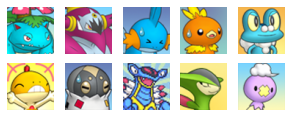

In [11]:
fig = plt.figure(figsize=(5, 5))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i], cmap='gray')
  plt.axis('off')
plt.savefig('dataset_tiny_example.png')
plt.show()

In [12]:
train_images_original = np.array(train_images, copy=True)
test_images_original = np.array(test_images, copy=True)

In [13]:
train_images.shape

(3660, 64, 64, 3)

<h3>Geração das mensagens secretas, aplicação do código de haming para aumentar a redundancia e armazenamento da mensagem secreta nos arquivos do dataset</h3>

In [14]:
def neededRedundantBits(m):
  for r in range(m + 1):
    if 2 ** r >= m + r + 1:
      return r
  return 0

In [15]:
tot = 1344

secretLength = 0

for i in range(tot + 1):
  if i + neededRedundantBits(i) == tot:
    secretLength = i
    break

print(tot, secretLength)

1344 1333


In [16]:
nHammer = tot - secretLength

In [17]:
# Função responsável por codificar a mensagem utilizando codificação de hammer
def preparaHammerArray(mensagem, nHammerBits):
  retorno = []

  j = 0
  k = 0

  for i in range(1, len(mensagem) + nHammerBits + 1):
    if i == 2 ** j:
      retorno.append(0)
      j += 1
    else:
      retorno.append(mensagem[k])
      k += 1

  for i in range(nHammerBits):
    x = 0

    for j in range(1, len(retorno) + 1):
      if j & (1 << i) == 1 << i:
        x ^= retorno[j-1]
    
    retorno[(1<<i) - 1] = x

  return retorno

In [18]:
# Função responsável por decodificar a mensagem utilizando codificação de hammer
def corrigeHammerArray(mensagem, nHammerBits):
  retorno = []

  j = 0

  for i in range(1, len(mensagem) + 1):
    if i == 2 ** j:
      retorno.append(0)
      j += 1
    else:
      retorno.append(mensagem[i - 1])

  for i in range(nHammerBits):
    x = 0

    for j in range(1, len(retorno) + 1):
      if j & (1 << i) == 1 << i:
        x ^= retorno[j-1]
    
    retorno[(1<<i) - 1] = x

  vet = ""

  for i in range(nHammerBits):
    vet += str(mensagem[(1<<i) - 1] ^ retorno[(1<<i) - 1])

  r = int(vet[::-1], 2)

  return r

In [19]:
preparaHammerArray([1, 1, 1, 1], 3)

[1, 1, 1, 1, 1, 1, 1]

In [20]:
corrigeHammerArray([1, 1, 1, 1, 1, 1, 1], 3)

0

In [21]:
# Função responsavél po gerar uma sequencia de bits que representa uma string aleatória, simulando a sequencia de bits de arquivos .txt
def generateStrBin(secretSize):
  message = []
  
  nChar = secretSize // 8

  randomStr = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(nChar))

  for i in randomStr:
    k = ord(i)
    for j in range(8):
      message.append(k & 1)
      k >>= 1

  while(len(message) < secretSize):
    message.append(0)

  return message

In [22]:
# armazena as mensagens secretas no dataset de treino
train_images2 = train_images
shape = train_images2.shape
train_images = np.zeros((shape[0], shape[1], shape[2], shape[3])).astype('int')

train_messages = [];

for i in trange(train_images2.shape[0]):
    message = generateStrBin(secretLength)

    message = preparaHammerArray(message, nHammer)
        
    train_messages.append(message)
    
    train_images[i] = stegano(train_images2[i], message).astype('int')
    
train_messages = np.array(train_messages)

  0%|          | 0/3660 [00:00<?, ?it/s]

In [23]:
# armazena as mensagens secretas no dataset de teste
test_images2 = test_images
shape = test_images2.shape
test_images = np.zeros((shape[0], shape[1], shape[2], shape[3])).astype('int')

test_messages = [];

for i in trange(test_images2.shape[0]):
    message = generateStrBin(secretLength)

    message = preparaHammerArray(message, nHammer)
        
    test_messages.append(message)
    
    test_images[i] = stegano(test_images2[i], message)
    
test_messages = np.array(test_messages)

  0%|          | 0/1221 [00:00<?, ?it/s]

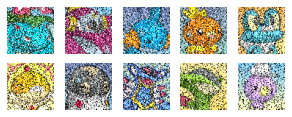

In [24]:
fig = plt.figure(figsize=(5, 5))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i], cmap='gray')
  plt.axis('off')
plt.savefig('dataset_tiny_noisy.png')
plt.show()

In [25]:
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images_original = train_images_original.astype('float32') / 255.
test_images_original = test_images_original.astype('float32') / 255.

print (train_images.shape)
print (test_images.shape)
print (train_images_original.shape)
print (test_images_original.shape)

(3660, 64, 64, 3)
(1221, 64, 64, 3)
(3660, 64, 64, 3)
(1221, 64, 64, 3)


<h3>Definição das topologias a serem testadas para o encoder e decoder</h3>

In [26]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [27]:
encoder = []

for j in range(1, 6):
  inputLayer = layers.Input(shape=(64, 64, 3))

  x = inputLayer

  for k in range(j):
    layersList = []
    x1 = layers.Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid' + str(k) + '_3x3')(x)
    layersList.append(x1)
    x2 = layers.Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid' + str(k) + '_4x4')(x)
    layersList.append(x2)
    x = layers.concatenate(layersList)
  
  outputLayer = layers.Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='sigmoid', name='output_C')(x)

  model = Model(inputs=inputLayer, outputs=outputLayer, name = 'Encoder')

  encoder.append(model)

In [28]:
encoder[0].summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_hid0_3x3 (Conv2D)         (None, 64, 64, 50)   1400        ['input_1[0][0]']                
                                                                                                  
 conv_hid0_4x4 (Conv2D)         (None, 64, 64, 10)   490         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 60)   0           ['conv_hid0_3x3[0][0]',          
                                                                  'conv_hid0_4x4[0][0]']    

In [29]:
decoder = []

for j in range(1, 6):
  inputLayer = layers.Input(shape=(64, 64, 3))

  x = inputLayer

  for k in range(j):
    layersList = []
    x1 = layers.Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev' + str(k) + '_3x3')(x)
    layersList.append(x1)
    x2 = layers.Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev' + str(k) + '_4x4')(x)
    layersList.append(x2)
    x = layers.concatenate(layersList)

  outputLayer = layers.Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='sigmoid', name='output_S')(x)

  model = Model(inputs=inputLayer, outputs=outputLayer, name = 'Decoder')

  decoder.append(model)

In [30]:
decoder[0].summary()

Model: "Decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_rev0_3x3 (Conv2D)         (None, 64, 64, 50)   1400        ['input_6[0][0]']                
                                                                                                  
 conv_rev0_4x4 (Conv2D)         (None, 64, 64, 10)   490         ['input_6[0][0]']                
                                                                                                  
 concatenate_15 (Concatenate)   (None, 64, 64, 60)   0           ['conv_rev0_3x3[0][0]',          
                                                                  'conv_rev0_4x4[0][0]']    

In [31]:
i = 0
for model in encoder:
  tf.keras.utils.plot_model(model, to_file='model_encoder_' + str(i) + '.png', show_shapes=True)
  i += 1

In [32]:
i = 0
for model in decoder:
  tf.keras.utils.plot_model(model, to_file='model_decoder_' + str(i) + '.png', show_shapes=True)
  i += 1

In [33]:
len(encoder)

5

In [34]:
len(decoder)

5

<h3>Treinamento da rede neural convolucional encoder</h3>

In [35]:
encoder_optimizer = []

for i in encoder:
  encoder_optimizer.append(tf.keras.optimizers.Adam())

In [36]:
decoder_optimizer = []

for i in decoder:
  decoder_optimizer.append(tf.keras.optimizers.Adam())

In [37]:
history = []

for i in range(len(encoder)):
  encoder[i].compile(optimizer='adam', loss=losses.MeanSquaredError())
  hist = encoder[i].fit(train_images, train_images_original,
                  epochs=20,
                  shuffle=False,
                  validation_data=(test_images, test_images_original))
  history.append(hist)

Epoch 1/20
115/115 [==============================] - 12s 12ms/step - loss: 0.0360 - val_loss: 0.0194
Epoch 2/20
115/115 [==============================] - 1s 9ms/step - loss: 0.0177 - val_loss: 0.0167
Epoch 3/20
115/115 [==============================] - 1s 9ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 4/20
115/115 [==============================] - 1s 9ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 5/20
115/115 [==============================] - 1s 10ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 6/20
115/115 [==============================] - 1s 9ms/step - loss: 0.0151 - val_loss: 0.0147
Epoch 7/20
115/115 [==============================] - 1s 9ms/step - loss: 0.0146 - val_loss: 0.0142
Epoch 8/20
115/115 [==============================] - 1s 9ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 9/20
115/115 [==============================] - 1s 9ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 10/20
115/115 [==============================] - 1s 9ms/step - loss: 0.0125 - val_loss: 0.0

In [38]:
print(history[0].history.keys())

dict_keys(['loss', 'val_loss'])


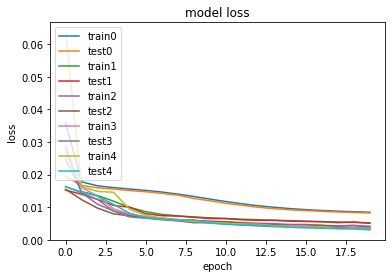

In [39]:
legend = []

i = 0

for hist in history:
  plt.plot(hist.history['loss'])
  legend.append('train' + str(i))

  plt.plot(hist.history['val_loss'])
  legend.append('test' + str(i))

  i += 1

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.savefig('first_training.png')
plt.show()

<h3>Treinamento adversarial das redes neurais convolucionais encoder e decoder</h3>

In [40]:
EPOCHS = 20
BATCH_SIZE = 32

In [41]:
mseFun = losses.MeanSquaredError()

In [42]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images, originalImages, enc, dec, enc_opt, dec_opt):
    with tf.GradientTape() as encoder_tape, tf.GradientTape() as decoder_tape:
      encoded_images = enc(images, training=True)
      decoded_images = dec(encoded_images, training=True)

      encoded_loss = mseFun(originalImages, encoded_images)
      decoded_loss = mseFun(images, decoded_images)
      total_loss = encoded_loss + decoded_loss

    gradients_of_encoder = encoder_tape.gradient(total_loss, enc.trainable_variables)
    gradients_of_decoder = decoder_tape.gradient(decoded_loss, dec.trainable_variables)

    enc_opt.apply_gradients(zip(gradients_of_encoder, enc.trainable_variables))
    dec_opt.apply_gradients(zip(gradients_of_decoder, dec.trainable_variables))

    return total_loss

In [43]:
def train(dataset, datasetTest, epochs, enc, dec, enc_opt, dec_opt):
  lossVet = []
  lossTestVet = []

  for epoch in trange(epochs):
    start = time.time()

    lenDataset = dataset.shape[0]
    nBatches = math.floor(lenDataset / BATCH_SIZE)

    total_loss = 0

    for i in trange(nBatches):
      total_loss += train_step(dataset[i:i + BATCH_SIZE], train_images_original[i:i + BATCH_SIZE], enc, dec, enc_opt, dec_opt)
    
    total_loss /= nBatches

    lossVet.append(total_loss)

    encoded_images_test = enc(datasetTest, training=False)
    decoded_images_test = dec(encoded_images_test, training=False)

    encoded_loss_test = mseFun(test_images_original, encoded_images_test)
    decoded_loss_test = mseFun(datasetTest, decoded_images_test)
    total_loss_test = encoded_loss_test + decoded_loss_test

    lossTestVet.append(total_loss_test)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return lossVet, lossTestVet

In [44]:
train_images_original.shape

(3660, 64, 64, 3)

In [45]:
history = []
historyTest = []

for i in range(len(encoder)):
  hist, histTest = train(train_images, test_images, EPOCHS, encoder[i], decoder[i], encoder_optimizer[i], decoder_optimizer[i])
  history.append(hist)
  historyTest.append(histTest)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 1 is 4.308148384094238 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 2 is 3.582423448562622 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 3 is 3.570651054382324 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 4 is 3.5773656368255615 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 5 is 3.615664482116699 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 6 is 3.5801961421966553 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 7 is 3.5472214221954346 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 8 is 3.609222888946533 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 9 is 3.5834896564483643 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 10 is 3.599771022796631 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 11 is 3.5796117782592773 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 12 is 3.5674874782562256 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 13 is 3.5617098808288574 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 14 is 3.6399099826812744 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 15 is 3.579068422317505 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 16 is 3.5808956623077393 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 17 is 3.5765669345855713 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 18 is 3.542426586151123 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 19 is 3.583209276199341 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 20 is 3.5674338340759277 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 1 is 8.282096147537231 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 2 is 7.583527088165283 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 3 is 7.557535648345947 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 4 is 7.574297189712524 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 5 is 7.576853036880493 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 6 is 7.566036224365234 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 7 is 7.5988969802856445 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 8 is 7.581997394561768 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 9 is 7.672080993652344 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 10 is 7.642063140869141 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 11 is 7.608346462249756 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 12 is 7.622109889984131 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 13 is 7.591325998306274 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 14 is 7.5946364402771 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 15 is 7.572214603424072 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 16 is 7.5729663372039795 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 17 is 7.5918707847595215 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 18 is 7.60637903213501 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 19 is 7.659295320510864 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 20 is 7.595284938812256 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 1 is 11.607964515686035 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 2 is 11.596166133880615 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 3 is 11.581389904022217 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 4 is 11.586047172546387 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 5 is 11.565593004226685 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 6 is 11.565742254257202 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 7 is 11.598394393920898 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 8 is 11.526610851287842 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 9 is 11.566204071044922 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 10 is 11.562987089157104 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 11 is 11.531574964523315 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 12 is 11.634891986846924 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 13 is 11.530359506607056 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 14 is 11.563336610794067 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 15 is 11.635612487792969 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 16 is 11.568955183029175 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 17 is 11.645440340042114 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 18 is 11.573688268661499 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 19 is 11.59838056564331 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 20 is 11.601383924484253 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 1 is 15.85143780708313 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 2 is 15.845942497253418 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 3 is 15.805444240570068 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 4 is 15.907072305679321 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 5 is 15.838184118270874 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 6 is 15.855294466018677 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 7 is 15.813839435577393 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 8 is 15.870112657546997 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 9 is 15.732115030288696 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 10 is 15.810578107833862 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 11 is 15.765599012374878 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 12 is 15.825959920883179 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 13 is 15.829545497894287 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 14 is 15.721129417419434 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 15 is 15.813385963439941 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 16 is 15.767801761627197 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 17 is 15.79784893989563 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 18 is 15.816177368164062 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 19 is 15.879419565200806 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 20 is 15.836540937423706 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 1 is 19.979667901992798 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 2 is 19.812633275985718 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 3 is 20.1501784324646 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 4 is 19.86730194091797 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 5 is 19.990445613861084 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 6 is 19.778385162353516 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 7 is 19.759167671203613 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 8 is 19.78966999053955 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 9 is 19.823039531707764 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 10 is 19.7778582572937 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 11 is 19.72218632698059 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 12 is 19.803767681121826 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 13 is 19.732582330703735 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 14 is 19.688745498657227 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 15 is 19.739829540252686 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 16 is 19.802098512649536 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 17 is 19.752053022384644 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 18 is 19.794663667678833 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 19 is 19.75112271308899 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 20 is 19.74712872505188 sec


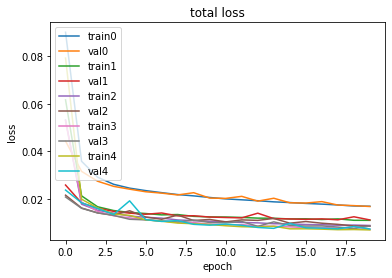

In [46]:
legend = []

for i in range(len(history)):
  plt.plot(history[i])
  legend.append('train' + str(i))

  plt.plot(historyTest[i])
  legend.append('val' + str(i))

plt.title('total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.savefig('second_training.png')
plt.show()

<h3>Avaliação dos resultados obtidos</h3>

In [47]:
encoded_imgs = []
decoded_imgs = []

for i in range(len(encoder)):
  encoded_imgs.append(encoder[i](test_images).numpy())
  decoded_imgs.append(decoder[i](encoded_imgs[i]).numpy())

  encoded_imgs[i] = encoded_imgs[i] * 255
  encoded_imgs[i] = encoded_imgs[i].astype('int')

  decoded_imgs[i] = decoded_imgs[i] * 255
  decoded_imgs[i] = decoded_imgs[i].astype('int')

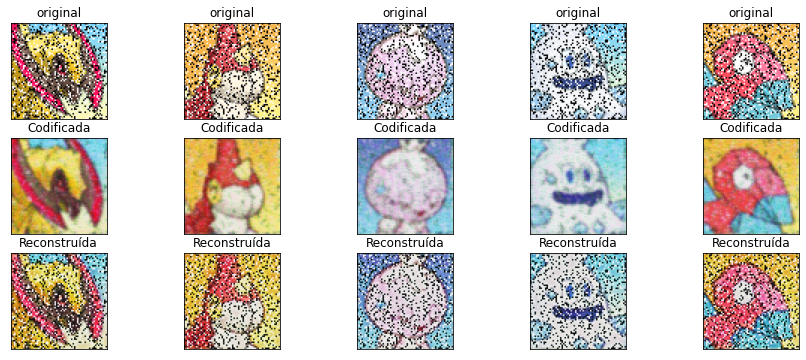

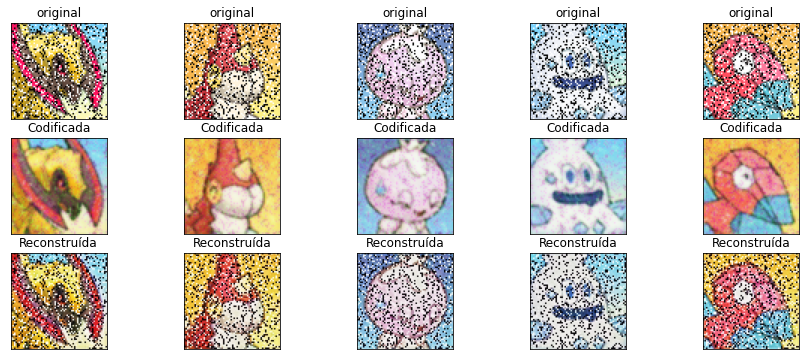

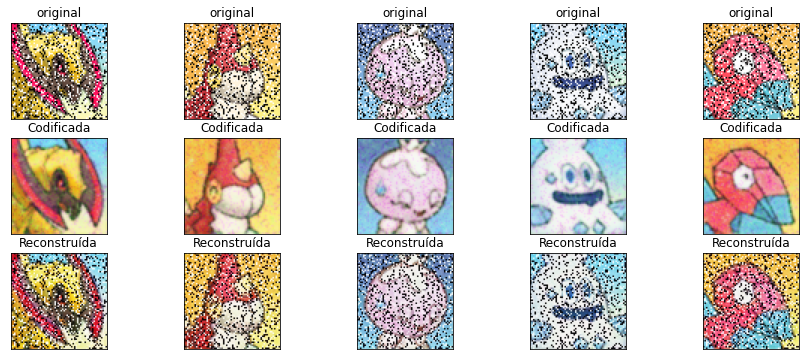

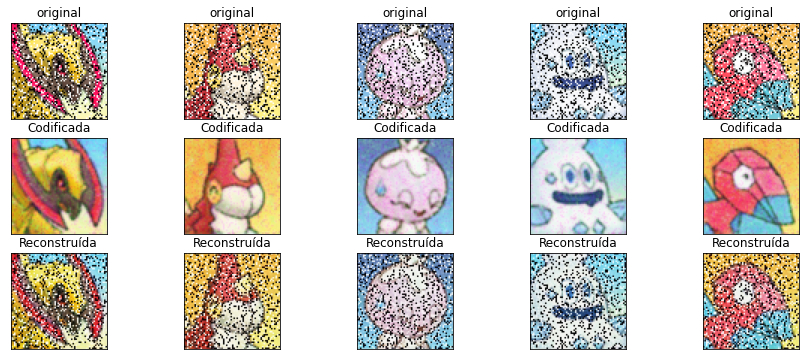

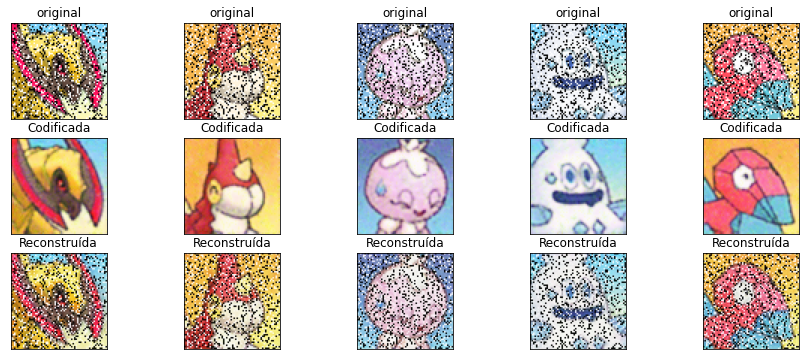

In [48]:
for k in range(len(encoder)):
  n = 5
  plt.figure(figsize=(15, 6))
  for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[k][i])
    plt.title("Codificada")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
      
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_imgs[k][i])
    plt.title("Reconstruída")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
  plt.savefig('img_results_' + str(k) + '.png')
  plt.show()

<h3>Medidas de semelhanças entre a imagem original e a imagem com a mensagem escodida</h3>

In [49]:
mseMean = []

for enc_set in encoded_imgs:
  enc_set = enc_set / 255
  mseSum = 0
  for i in range(test_images_original.shape[0]):
    mseSum += mean_squared_error(test_images_original[i], enc_set[i])
    
  mseMean.append(mseSum / test_images_original.shape[0])

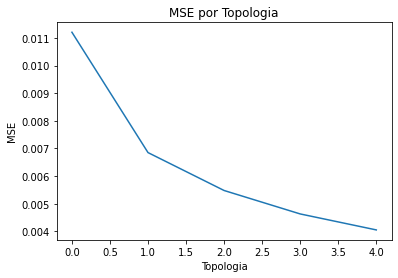

In [50]:
plt.plot(mseMean)
plt.title('MSE por Topologia')
plt.ylabel('MSE')
plt.xlabel('Topologia')
plt.savefig('mse_por_topologia.png')
plt.show()

In [51]:
mseFun(test_images_original[0], encoded_imgs[0])

<tf.Tensor: shape=(), dtype=int64, numpy=26565>

<h3>Média de erro de bit na recuperação das mensagens secretas por topologia</h3>

In [52]:
def erroBits(x, y):
  qtd = 0

  for i in range(x.shape[0]):
    if x[i] != y[i]:
      qtd += 1

  return qtd

In [53]:
listaMediaErro = []
listaMediaErroSemHammer = []

for k in range(len(encoder)):
  mediaErro = 0
  mediaErroSemHammer = 0

  j = 0

  for i in decoded_imgs[k]:
      a = np.array(i, copy=True)
      msgA = steganoInv(a)

      erroValorSemHammer = erroBits(test_messages[j], msgA)

      mediaErroSemHammer += erroValorSemHammer

      idxBitErro = corrigeHammerArray(msgA, nHammer)
      if idxBitErro > 0:
        msgA[idxBitErro - 1] = ~msgA[idxBitErro - 1] & 1
      
      erroValor = erroBits(test_messages[j], msgA)

      mediaErro += erroValor

      j += 1

  mediaErro /= decoded_imgs[k].shape[0]
  mediaErroSemHammer /= decoded_imgs[k].shape[0]

  listaMediaErro.append(mediaErro)
  listaMediaErroSemHammer.append(mediaErroSemHammer)

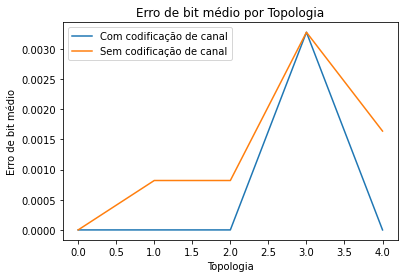

In [54]:
legend = []

plt.plot(listaMediaErro)
legend.append('Com codificação de canal')
plt.plot(listaMediaErroSemHammer)
legend.append('Sem codificação de canal')
plt.title('Erro de bit médio por Topologia')
plt.ylabel('Erro de bit médio')
plt.xlabel('Topologia')
plt.legend(legend, loc='upper left')
plt.savefig('erro_de_bit_medio_por_topologia.png')
plt.show()